## List

1. 64360612 กิติพงษ์ สายยศ
2. 64362968 ธิติพล แพ่งเมือง
3. 64366584 สุปกาณฑ์ อ่วมวงษ์
4. 64366744 สุวัชชัย พิณเนียม
5. 64365570 วัชระพงศ์ รอดพงษ์

### Random Forest

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

### Feature Engineering with Convolution Images.

In [6]:
def conv2d(image, kernel):
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel.shape

    output_h = image_h - kernel_h + 1
    output_w = image_w - kernel_w + 1
    
    output = np.zeros((output_h, output_w)) 

    for i in range(output_h):
        for j in range(output_w):
            region = image[i:i + kernel_h, j:j + kernel_w]
            output[i, j] = np.sum(region * kernel)
    return output

def apply_conv(dataset, kernel):
    output_dataset = np.zeros((dataset.shape[0], 
                                dataset.shape[1] - kernel.shape[0] + 1, 
                                dataset.shape[2] - kernel.shape[1] + 1))
    for idx in range(dataset.shape[0]):
        output_dataset[idx] = conv2d(dataset[idx], kernel)
    return output_dataset

kernel = np.array([[0.2, 0.1, 0.4],
                   [0.5, 0.3, 0.2],
                   [0.3, 0.2, 0.5]])

In [4]:
x_train_conv = apply_conv(x_train, kernel=kernel)
x_test_conv = apply_conv(x_test, kernel=kernel)

In [5]:
x_train_conv.shape, x_test_conv.shape

((60000, 26, 26), (10000, 26, 26))

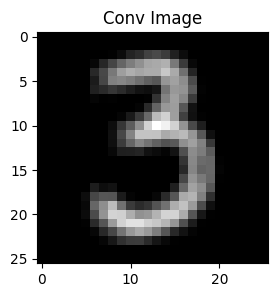

In [6]:
plt.figure(figsize=(3,3))
plt.title('Conv Image')
plt.imshow(x_train_conv[50], cmap='gray')

plt.show()

In [7]:
x_train = x_train_conv.reshape(-1, x_train_conv.shape[1] * x_train_conv.shape[2]).astype('float32') / 255.0
x_test = x_test_conv.reshape(-1, x_test_conv.shape[1] * x_test_conv.shape[2]).astype('float32') / 255.0

x_train.shape, x_test.shape

((60000, 676), (10000, 676))

In [8]:
rf_model = RandomForestClassifier(n_estimators=5, random_state=42)
rf_model.fit(x_train, y_train)
y_pred = rf_model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest accuracy on MNIST: {accuracy:.4f}")

Random Forest accuracy on MNIST: 0.9399


### Confusion Matrix

In [9]:
confusion_matrix = tf.math.confusion_matrix(y_test, y_pred)

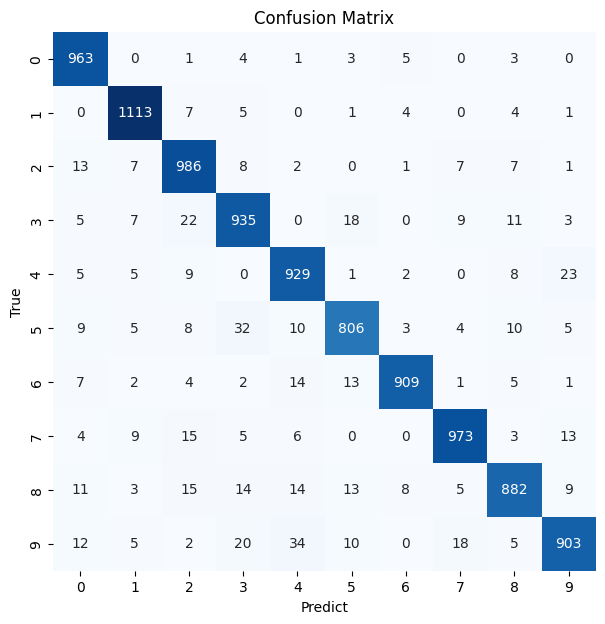

In [10]:
plt.figure(figsize=(7, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predict')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Classification Report
- Precision
- Recall
- F1-Score
- Accuracy

In [11]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

precision_ = precision_score(y_test, y_pred, average='weighted')
recall_ = recall_score(y_test, y_pred, average='weighted')
f1_ = f1_score(y_test, y_pred, average='weighted')

accuracy_ = accuracy_score(y_test, y_pred)

_metrics = {
    'Precision': precision_,
    'Recall': recall_,
    'F1-Score': f1_,
    'Accuracy': accuracy_
}

df_matrix = pd.DataFrame([_metrics])
print("Classification Report")
df_matrix

Classification Report


,Precision,Recall,F1-Score,Accuracy
0,0.940133,0.9399,0.939767,0.9399


## Hyper Parameter Tunning
Use RandomizedSearchCV, a method that randomizes the values ​​of the hyperparameters specified in param_grid and then trains and evaluates the model using cross-validation to find the set of hyperparameters that gives the best results.

In [12]:
param_grid = { 
    'n_estimators': [6, 7, 8, 9, 10, 12, 15, 20, 25, 50, 100], 
    'max_features':['auto','sqrt','log2'],
    'criterion': ["gini", "entropy", "log_loss"]
} 

In [13]:
rf = RandomForestClassifier(random_state=42)

rf_random_search = RandomizedSearchCV(estimator=rf,
                                      param_distributions=param_grid,
                                      n_iter=10, 
                                      cv=3,  
                                      verbose=2,
                                      random_state=42,
                                      n_jobs=-1) 

In [14]:
rf_random_search.fit(x_train, y_train);
print(f"Best hyperparameters: {rf_random_search.best_params_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best hyperparameters: {'n_estimators': 50, 'max_features': 'log2', 'criterion': 'log_loss'}


#### Show Performance while grid search

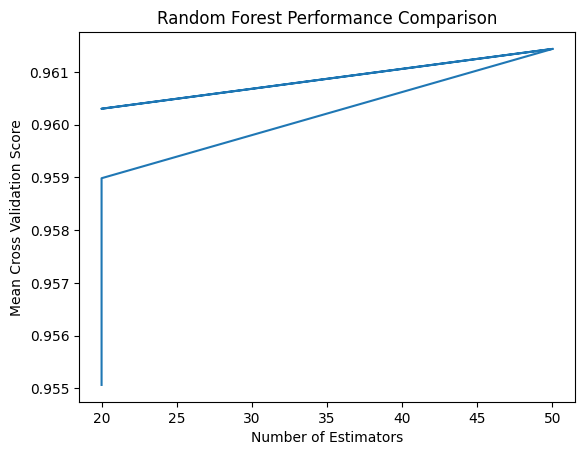

In [25]:
results_rf = pd.DataFrame(rf_random_search.cv_results_['params'])
results_rf['test_score'] = rf_random_search.cv_results_['mean_test_score']

plt.plot(results_rf['n_estimators'], results_rf['test_score'])
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Cross Validation Score')
plt.title('Random Forest Performance Comparison')
plt.show()

In [16]:
best_rf_model = rf_random_search.best_estimator_    # Best model

pred_test = best_rf_model.predict(x_test)
accuracy = accuracy_score(y_test, pred_test)
print(f"Accuracy of tuned RandomForest on MNIST: {accuracy:.4f}")

Accuracy of tuned RandomForest on MNIST: 0.9660


#### Confusion Matrix on Tuning Model

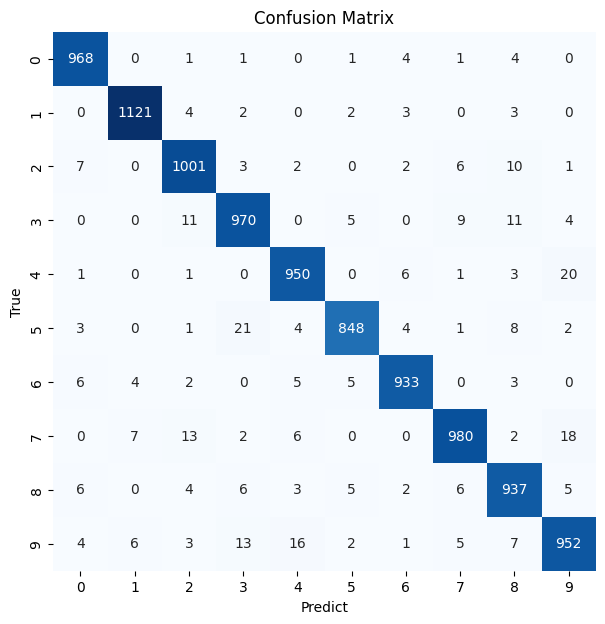

In [17]:
confusion_ = tf.math.confusion_matrix(y_test, pred_test)
plt.figure(figsize=(7, 7))
sns.heatmap(confusion_, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predict')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### Evaluation on Tunning Model
- Precision
- Recall
- F1-Score
- Accuracy 


In [18]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

precision_1 = precision_score(y_test, pred_test, average='weighted')
recall_1 = recall_score(y_test, pred_test, average='weighted')
f1_1 = f1_score(y_test, pred_test, average='weighted')

accuracy_1 = accuracy_score(y_test, pred_test)

_metrics1 = {
    'Precision': precision_1,
    'Recall': recall_1,
    'F1-Score': f1_1,
    'Accuracy': accuracy_1
}

df_matrix1 = pd.DataFrame([_metrics1])
print("Classification Report")
df_matrix1

Classification Report


,Precision,Recall,F1-Score,Accuracy
0,0.966053,0.966,0.965986,0.966


### Display Image that predicted is correct and incorrect

In [19]:
def display_one_prediction(images, true_labels, pred_labels):
    correct = np.where(true_labels == pred_labels)[0]
    incorrect = np.where(true_labels != pred_labels)[0]

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    if len(correct) > 0:
        random_correct = np.random.choice(correct)
        axs[0].imshow(images[random_correct].reshape(x_train_conv.shape[1], x_train_conv.shape[2]), cmap='gray')
        axs[0].set_title(f"Correct\nPred: {pred_labels[random_correct]}, True: {true_labels[random_correct]}")
    else:
        axs[0].axis('off')

    if len(incorrect) > 0:
        random_incorrect = np.random.choice(incorrect)
        axs[1].imshow(images[random_incorrect].reshape(x_train_conv.shape[1], x_train_conv.shape[2]), cmap='gray')
        axs[1].set_title(f"Incorrect\nPred: {pred_labels[random_incorrect]}, True: {true_labels[random_incorrect]}")
    else:
        axs[1].axis('off')

    plt.tight_layout()
    plt.show()


In [20]:
x_test_reshaped_inverted = x_test.reshape(-1, x_train_conv.shape[1], x_train_conv.shape[2])

### Display images after Tunning

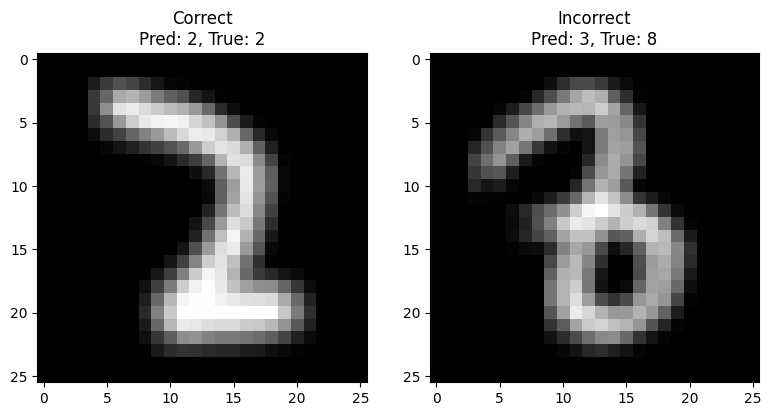

In [21]:
display_one_prediction(x_test_reshaped_inverted, y_test, pred_test)

#### Compare between before and after hyperparameter Tuning

In [22]:
print("\nBefore Tuning...")
print(df_matrix)
print("\n----------------------------------------------------\n")
print("After Tuning...")
print(df_matrix1)


Before Tuning...
   Precision  Recall  F1-Score  Accuracy
0   0.940133  0.9399  0.939767    0.9399

----------------------------------------------------

After Tuning...
   Precision  Recall  F1-Score  Accuracy
0   0.966053   0.966  0.965986     0.966


### Classification Report

In [16]:
from sklearn.metrics import classification_report
pred_test = best_rf_model.predict(x_test)
report_rf = classification_report(y_test, pred_test)
print("Classification Report for Random Forest Model:\n", report_rf)

Classification Report for Random Forest Model:
               precision    recall  f1-score   support

           0       0.83      0.97      0.90       980
           1       0.97      0.97      0.97      1135
           2       0.92      0.91      0.92      1032
           3       0.86      0.76      0.81      1010
           4       0.97      0.81      0.88       982
           5       0.97      0.64      0.78       892
           6       0.95      0.93      0.94       958
           7       0.97      0.82      0.89      1028
           8       0.60      0.95      0.74       974
           9       0.81      0.86      0.83      1009

    accuracy                           0.86     10000
   macro avg       0.89      0.86      0.86     10000
weighted avg       0.89      0.86      0.87     10000



In [23]:
import os

directory = "model"

if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Directory '{directory}' created.")
else:
    print(f"Directory '{directory}' already exists.")

Directory 'model' created.


In [ ]:
import joblib

joblib.dump(best_rf_model, 'model/rf_mnist_model.pkl')